# IEOR4742 Deep Learning -- Time Series Forecast 2

- codes here are meant to be run sequentially
- for a modularized version, see folder code/

# Project Abstract

Alternative data are data collected from non-traditional sources and are used by investment firms to gain competitive edge. Examples of alternative features of mutual funds include administrators, auditors, custodians, distributors and managers, to name but a few. In this project, we combined the time-series data and alternative data to predict the future performance of mutual funds and two prediction frameworks are proposed: (1) AltFNN, a simple feedforward network (FNN) that merges time-series and alternative data, and (2) LSTM-AltReg/FNN, a separate architecture with two sub-networks -- Long Short-Term Memory (LSTM) for time-series and regression/feedforward network for alternative data. The performance of the two frameworks and their variations are compared. It is observed that, while predictions using historical excess returns alone are not satisfactory, alternative data add predictive power, showing improvements in terms of mean-squared errors.

## Contributors

- Bowen Zhang (bz2399)
- Chun Yat Yeung (cy2623)

# Configuration

- import packages, such as: numpy, pandas, statsmodels, sklearn, keras, etc. and define data file locations
- users should modify DATA_ROOT appropriately

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "drive/MyDrive/WM_TSForecast2/"

/content/drive/MyDrive/WM_TSForecast2


In [3]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
import os

DATA_ROOT = "drive/MyDrive/WM_TSForecast2/"

PATH_DICT = {
    'categories':       'MF_LargeCap_Categories.parquet',
    'excess_return':    'MF_LargeCap_ExcessReturn_3Y.parquet',
    'fund_size':        'MF_LargeCap_FundSize.parquet',
    'opt_people':       'opt_people.parquet',
}

PATH_DICT = {key: os.path.join(DATA_ROOT, direc) for key, direc in PATH_DICT.items()}
PATH_DICT

{'categories': 'drive/MyDrive/WM_TSForecast2/MF_LargeCap_Categories.parquet',
 'excess_return': 'drive/MyDrive/WM_TSForecast2/MF_LargeCap_ExcessReturn_3Y.parquet',
 'fund_size': 'drive/MyDrive/WM_TSForecast2/MF_LargeCap_FundSize.parquet',
 'opt_people': 'drive/MyDrive/WM_TSForecast2/opt_people.parquet'}

# Preliminary Analysis of Dataset

- a glimpse into the 4 parquet data files, including: 
    * MF_LargeCap_Categories.parquet
    * MF_LargeCap_ExcessReturn_3Y.parquet
    * MF_LargeCap_FundSize.parquet
    * opt_people.parquet
- notice the features and values associated to the data files

## Data: Categories

In [ ]:
categories = pd.read_parquet(PATH_DICT['categories'], engine='pyarrow')
categories.shape, categories.columns, categories.index, categories.head(), categories.tail()

((260, 1330),
 Index(['B42', 'B45', 'B50', 'B56', 'B113', 'B209', 'B228', 'B235', 'B241',
        'B245',
        ...
        'B26017', 'B26020', 'B26022', 'B26031', 'B26041', 'B26042', 'B26061',
        'B26063', 'B26070', 'B26072'],
       dtype='object', length=1330),
 Index(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06',
        '2000-07', '2000-08', '2000-09', '2000-10',
        ...
        '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
        '2021-05', '2021-06', '2021-07', '2021-08'],
       dtype='object', name='Month', length=260),
                             B42                  B45   B50  ... B26063 B26070 B26072
 Month                                                       ...                     
 2000-01  US Fund Mid-Cap Growth  US Fund Large Value  None  ...   None   None   None
 2000-02  US Fund Mid-Cap Growth  US Fund Large Value  None  ...   None   None   None
 2000-03  US Fund Mid-Cap Growth  US Fund Large Value  None  ...   No

In [ ]:
categories.apply(lambda col: ', '.join(list(map(str, categories.iloc[:,0].unique()))), axis=1)[0]

'US Fund Mid-Cap Growth, US Fund Mid-Cap Blend, US Fund Large Blend, None'

## Data: Excess Return

In [11]:
excess_return = pd.read_parquet(PATH_DICT['excess_return'], engine='pyarrow')
excess_return.shape, excess_return.columns, excess_return.index, excess_return.head(), excess_return.tail()

((6818, 1330),
 Index(['B42', 'B45', 'B50', 'B56', 'B113', 'B209', 'B228', 'B235', 'B241',
        'B245',
        ...
        'B26017', 'B26020', 'B26022', 'B26031', 'B26041', 'B26042', 'B26061',
        'B26063', 'B26070', 'B26072'],
       dtype='object', length=1330),
 DatetimeIndex(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04',
                '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
                '2003-01-09', '2003-01-10',
                ...
                '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25',
                '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29',
                '2021-08-30', '2021-08-31'],
               dtype='datetime64[ns]', name='Date', length=6818, freq=None),
                  B42       B45  B50  B56  ...  B26061  B26063  B26070  B26072
 Date                                      ...                                
 2003-01-01 -0.004930  0.023239  NaN  NaN  ...     NaN     NaN     NaN     NaN
 2003-01-02 -0.0

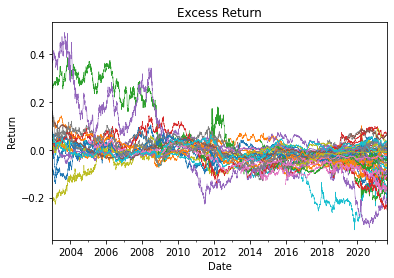

In [ ]:
n_funds = 50
plt.title('Excess Return')
plt.ylabel('Return')
for k in range(n_funds):
    rtn_series = excess_return.iloc[:,k]
    rtn_series = rtn_series[rtn_series.first_valid_index():rtn_series.last_valid_index()]
    rtn_series.plot(linewidth=0.5)

## Data: Fund Size

In [ ]:
fund_size = pd.read_parquet(PATH_DICT['fund_size'], engine='pyarrow')
fund_size.shape, fund_size.columns, fund_size.index, fund_size.head(), fund_size.tail()

((260, 1330),
 Index(['B42', 'B45', 'B50', 'B56', 'B113', 'B209', 'B228', 'B235', 'B241',
        'B245',
        ...
        'B26017', 'B26020', 'B26022', 'B26031', 'B26041', 'B26042', 'B26061',
        'B26063', 'B26070', 'B26072'],
       dtype='object', length=1330),
 Index(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06',
        '2000-07', '2000-08', '2000-09', '2000-10',
        ...
        '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
        '2021-05', '2021-06', '2021-07', '2021-08'],
       dtype='object', name='Month', length=260),
                  B42           B45  B50  B56  ...  B26061  B26063  B26070  B26072
 Month                                         ...                                
 2000-01  137696263.0  1.537495e+09  NaN  NaN  ...     NaN     NaN     NaN     NaN
 2000-02  279878290.0  1.515704e+09  NaN  NaN  ...     NaN     NaN     NaN     NaN
 2000-03  369333374.0  1.599402e+09  NaN  NaN  ...     NaN     NaN     NaN     Na

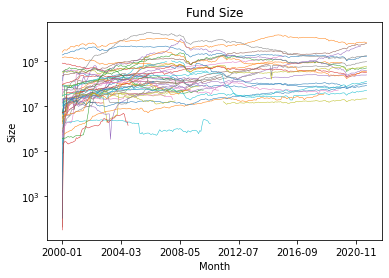

In [ ]:
n_funds = 50
plt.grid()
plt.title('Fund Size')
plt.ylabel('Size')
for k in range(n_funds):
    size_series = fund_size.iloc[:,k]
    size_series = size_series[size_series.first_valid_index():size_series.last_valid_index()]
    size_series.plot(logy=True, linewidth=0.5)

## Data: Opt People

In [ ]:
opt_people = pd.read_parquet(PATH_DICT['opt_people'], engine='pyarrow')
opt_people.shape, opt_people.columns, opt_people.index, opt_people.head(), opt_people.tail()

((1330, 12),
 Index(['Administrator', 'Advisor', 'Auditor', 'Auditor \nFee', 'Custodian',
        'Distributor', 'Manager History', 'Manager of Managers',
        'Manager Ownership Level', 'Subadvised', 'Subadvisor',
        'Superannuation'],
       dtype='object'),
 Index(['B42', 'B45', 'B50', 'B56', 'B113', 'B209', 'B228', 'B235', 'B241',
        'B245',
        ...
        'B26017', 'B26020', 'B26022', 'B26031', 'B26041', 'B26042', 'B26061',
        'B26063', 'B26070', 'B26072'],
       dtype='object', name='ASK_ID', length=1330),
                                             Administrator  ... Superannuation
 ASK_ID                                                     ...               
 B42                        American Century Services, LLC  ...             No
 B45                                                  None  ...             No
 B50     American Century Services, LLC;State Street Ba...  ...             No
 B56                            J. P. Morgan Chase Bank NA  ...

In [ ]:
opt_people.head()

,Administrator,Advisor,Auditor,Auditor \nFee,Custodian,Distributor,Manager History,Manager of Managers,Manager Ownership Level,Subadvised,Subadvisor,Superannuation
ASK_ID,,,,,,,,,,,,
B42,"American Century Services, LLC",American Century Investment Management Inc,Deloitte & Touche LLP,NaN,State Street Bank & Trust Co,American Century Investment Sv Inc,[1999-11-30 -- 2005-02-28] James E. Stowers;[1...,No,None,No,None,No
B45,None,"BNY Mellon Investment Adviser, Inc.",Ernst & Young LLP,NaN,The Bank of New York Mellon,BNY Mellon Securities Corporation,[1997-07-22 -- 2004-10-05] Douglas D. Ramos;[1...,No,None,No,None,No
B50,"American Century Services, LLC;State Street Ba...",American Century Investment Management Inc,Pricewaterhousecoopers LLP,NaN,State Street Bank & Trust Co,American Century Investment Sv Inc,[2011-10-31 -- 2016-05-18] William Martin;[201...,No,Claudia Musat [$0 - None];Steven Rossi [$0 - N...,No,None,No
B56,J. P. Morgan Chase Bank NA,AQR Capital Management LLC,Pricewaterhousecoopers LLP,0.22,JPMorgan Chase Bank;State Street Bank And Trus...,ALPS Distributors Inc,[2016-12-14 -- 2019-12-20] Jacques A. Friedman...,No,None,No,None,No
B113,Commonwealth Fund Services Inc,CBOE Vest Financial LLC,"Cohen & Company, Ltd.",0.03,Fifth Third Bank,First Dominion Capital Corp,[2018-05-21 -- 2019-09-13] Rachel Ames;[2017-0...,No,Howard Rubin [$0 - None];Karan Sood [NA - FC I...,No,None,No


In [ ]:
opt_people['Advisor'].unique()[:10]

array(['American Century Investment Management Inc',
       'BNY Mellon Investment Adviser, Inc.',
       'AQR Capital Management LLC', 'CBOE Vest Financial LLC',
       'BlackRock Advisors LLC', 'Brown Brothers Harriman & Co.',
       'Applied Finance Advisors LLC', 'Investment Research Corporation',
       'Legg Mason Partners Fund Advisor, LLC',
       'Clarkston Capital Partners, LLC'], dtype=object)

In [ ]:
opt_people = opt_people.drop('Auditor \nFee', axis=1)

## Single Fund B42

- visualize B42 excess return and fund size over time

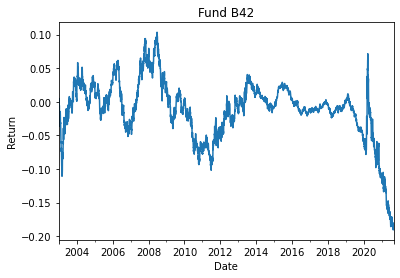

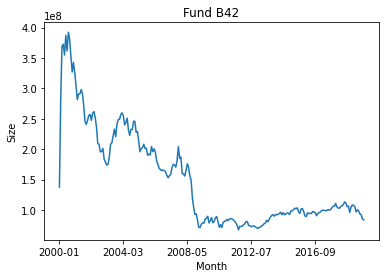

In [ ]:
fund = excess_return.columns[0]
rtn_series = excess_return.loc[:,fund]
size_series = fund_size.loc[:,fund]

rtn_series.plot()
plt.title(f'Fund {fund}')
plt.ylabel('Return')
plt.show()

size_series.plot()
plt.title(f'Fund {fund}')
plt.ylabel('Size')
plt.show()

# Single-Fund Analysis

Without loss of generality, we picked a particular fund, named B42, and assessed its performance relative to other mutual funds, in order to gain intuition for the excess return time series.

## Funds with sufficiently long return history

We chose 2012-05-13 to 2020-04-07 as our timeframe, between which over 4000 days exist, and within this period, 866 funds are filtered out, including B45, B209 and so on.

In [ ]:
selected_funds = list(excess_return.columns[excess_return.count()>4000])
len(selected_funds), selected_funds[:5]

(866, ['B42', 'B45', 'B209', 'B241', 'B350'])

In [ ]:
common_idx = excess_return[selected_funds[0]]
common_idx = set(common_idx[common_idx>0].index)
for name, rtn in excess_return[selected_funds].iteritems():
    common_idx = common_idx.intersection(rtn[rtn.notna()].index)
common_idx = sorted(list(common_idx))

In [ ]:
common_idx[:5], common_idx[-5:], len(common_idx)

([Timestamp('2012-05-13 00:00:00'),
  Timestamp('2012-05-14 00:00:00'),
  Timestamp('2012-05-15 00:00:00'),
  Timestamp('2012-05-16 00:00:00'),
  Timestamp('2012-05-17 00:00:00')],
 [Timestamp('2020-04-03 00:00:00'),
  Timestamp('2020-04-04 00:00:00'),
  Timestamp('2020-04-05 00:00:00'),
  Timestamp('2020-04-06 00:00:00'),
  Timestamp('2020-04-07 00:00:00')],
 1002)

In [ ]:
excess_return_selected = excess_return[selected_funds].loc[common_idx]
excess_return_selected.shape, excess_return_selected.index, excess_return_selected.head(), excess_return_selected.describe()

((1002, 866),
 DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
                '2012-05-17', '2012-06-23', '2012-10-28', '2012-10-29',
                '2012-10-30', '2012-10-31',
                ...
                '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
                '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
                '2020-04-06', '2020-04-07'],
               dtype='datetime64[ns]', name='Date', length=1002, freq=None),
                  B42       B45      B209  ...    B26022    B26042    B26061
 Date                                      ...                              
 2012-05-13  0.008976 -0.003126 -0.025190  ... -0.021569 -0.009263 -0.017416
 2012-05-14  0.005727 -0.004066 -0.025916  ... -0.024258 -0.013597 -0.016861
 2012-05-15  0.004217 -0.004593 -0.027445  ... -0.024894 -0.010078 -0.017289
 2012-05-16  0.003374 -0.005164 -0.028629  ... -0.026197 -0.010316 -0.017340
 2012-05-17  0.003109 -0.006923 -0.029560  ... -0.

## Regression of B42 fund return vs other funds

As mutual funds are carrying out similar strategies, for instance, long-short in particular sectors/industries, geographic concentrations etc., one can expect that some mutual funds may be replicated well with other funds, exhibiting a high correlation between their excess returns. To see this, we performed a regression of B42 returns versus other funds that exist for a comparable history. Regression is applied to B42 daily (rolling) returns, with returns of the other 866 funds as features. To simplify the model, recursively we picked features that exhibited "sufficiently high" $t$-statistics, at a threshold of 2, and concluded that B42 fund may be replicated well with just 43 other funds, yet achieving an adjusted R-squared of $95.5\%$.

In [ ]:
# return regression
fund = excess_return_selected.columns[0]
return_data = excess_return_selected.copy()
dataX = return_data.drop(fund, axis=1)
dataY = return_data[fund]
dataX.reset_index(drop=True, inplace=True)
dataY.reset_index(drop=True, inplace=True)

# fit regression
dataX = sm.add_constant(dataX)
mod = sm.OLS(dataY, dataX)
res = mod.fit()
print('fund:', fund)
res.summary()

fund: B42


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    B42   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     580.7
Date:                Wed, 29 Dec 2021   Prob (F-statistic):          2.43e-158
Time:                        20:48:57   Log-Likelihood:                 7255.9
No. Observations:                1002   AIC:                        -1.278e+04
Df Residuals:                     136   BIC:                            -8528.
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0448      0.034      1.305      0.194      -0.023       0.113
B45            0.6634      0.253      2.625      0.010       0.164       1.163
B209          -0.4929      0.187     -2.635      0.009      -0.863      -0.123
B241          -0.0830      0.057     -1.459      0.147      -0.196       0.029
B350           0.0771      0.137      0.561      0.576      -0.195       0.349
B356          -0.0757      0.082     -0.920      0.359      -0.238       0.087
B373          -0.0024      0.178     -0.013      0.989      -0.354       0.350
B382           0.2912      0.181      1.613      0.109      -0.066       0.648
B387          -0.1006      0.098     -1.021      0.309      -0.295       0.094
B392          -0.0597      0.096     -0.623      0.534      -0.249       0.130
B397           0.0532      0.083      0.643      0.522      -0.111       0.217
B404           0.0483      0.054      0.896      0.372      -0.058       0.155
B405          -0.1076      0.077     -1.392      0.166      -0.260       0.045
B406           0.0858      0.064      1.346      0.181      -0.040       0.212
B635           0.0165      0.137      0.121      0.904      -0.254       0.287
B656          -0.1297      0.170     -0.763      0.447      -0.466       0.206
B671           0.2610      0.094      2.773      0.006       0.075       0.447
B687          -0.2785      0.100     -2.786      0.006      -0.476      -0.081
B701           0.1235      0.322      0.383      0.702      -0.514       0.761
B762          -0.2469      0.158     -1.562      0.120      -0.559       0.066
B800          -0.0560      0.085     -0.663      0.509      -0.223       0.111
B816          -0.0483      0.114     -0.422      0.673      -0.275       0.178
B844           0.2131      0.101      2.100      0.038       0.012       0.414
B850          -0.1325      0.123     -1.077      0.284      -0.376       0.111
B851          -0.3754      0.129     -2.911      0.004      -0.630      -0.120
B896          -0.0549      0.235     -0.233      0.816      -0.520       0.411
B901          -0.0144      0.118     -0.122      0.903      -0.248       0.219
B936          -0.1397      0.170     -0.821      0.413      -0.476       0.197
B938          -0.0264      0.149     -0.177      0.859      -0.320       0.268
B948           0.0863      0.067      1.292      0.198      -0.046       0.218
B1009          0.0916      0.104      0.884      0.378      -0.113       0.296
B1013         -0.1780      0.230     -0.775      0.440      -0.632       0.276
B1028          0.0644      0.179      0.359      0.720      -0.290       0.419
B1060          0.6313      0.323      1.954      0.053      -0.008       1.270
B1061         -0.2611      0.118     -2.210      0.029      -0.495      -0.027
B1109         -2.1661      1.554     -1.394      0.166      -5.240       0.908
B1

In [ ]:
tvalues_thres = 2
while len(res.tvalues[res.tvalues.abs() < tvalues_thres].index) > 1:
    selected_cols = list(res.tvalues[res.tvalues.abs() > tvalues_thres].index)
    dataX = dataX[selected_cols]
    dataX = sm.add_constant(dataX)
    mod = sm.OLS(dataY, dataX)
    res = mod.fit()
    print('fund:', fund)
    print(res.summary())
selected_cols[:10]

fund: B42
                            OLS Regression Results                            
Dep. Variable:                    B42   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     302.3
Date:                Wed, 29 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:48:58   Log-Likelihood:                 4748.7
No. Observations:                1002   AIC:                            -9349.
Df Residuals:                     928   BIC:                            -8986.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0114      0.005      2.49

['const',
 'B45',
 'B209',
 'B687',
 'B844',
 'B851',
 'B1061',
 'B1286',
 'B1319',
 'B1853']

Plot of B42 return vs predictors w/ high t-stats


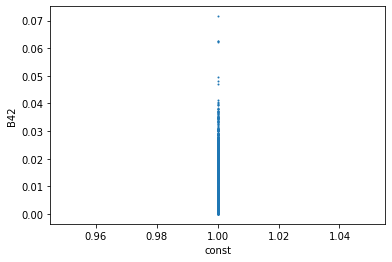

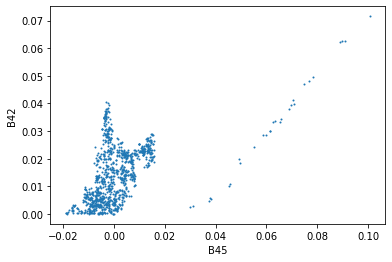

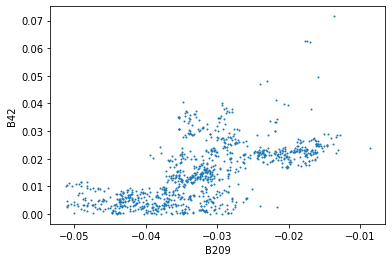

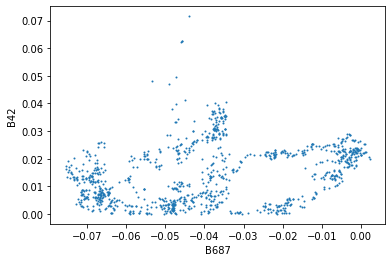

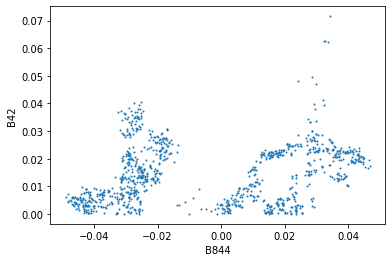

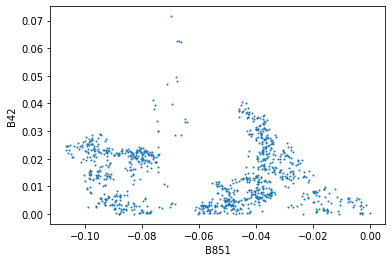

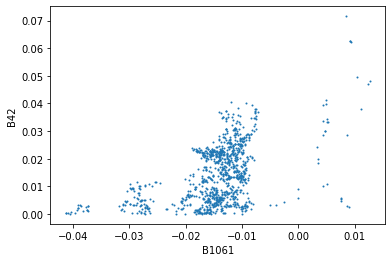

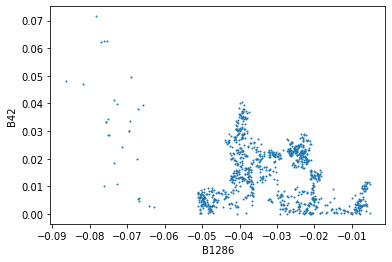

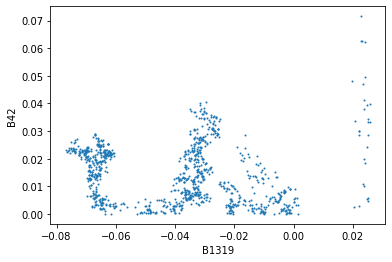

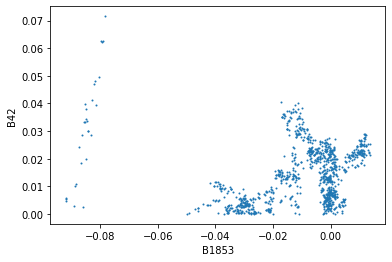

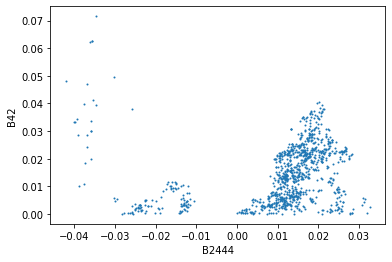

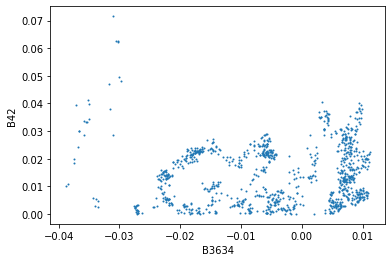

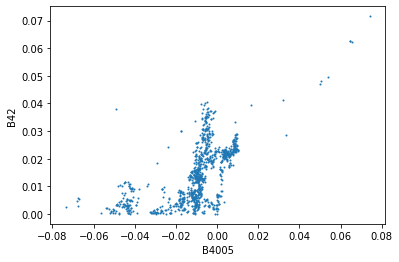

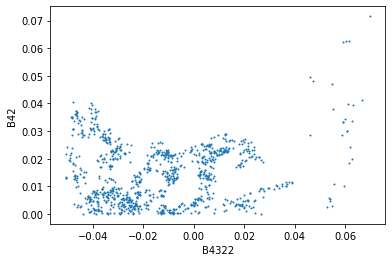

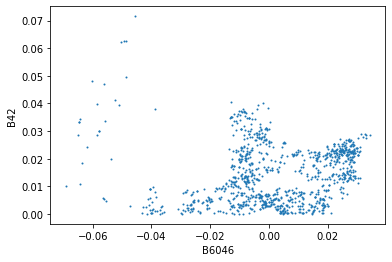

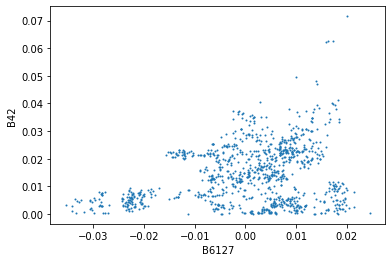

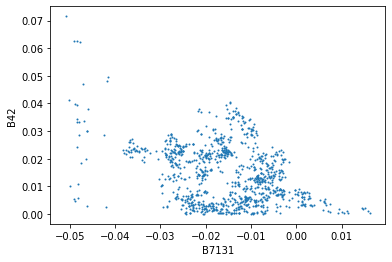

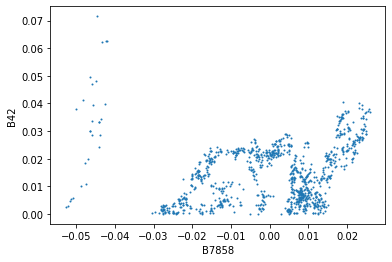

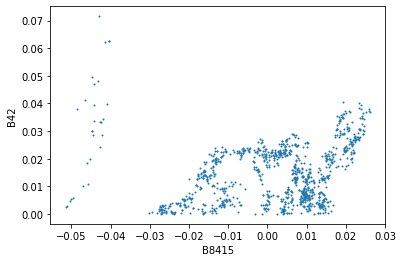

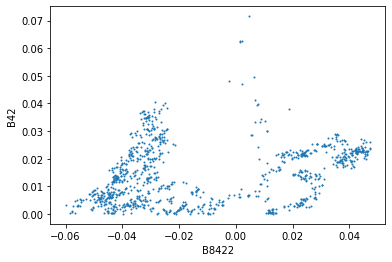

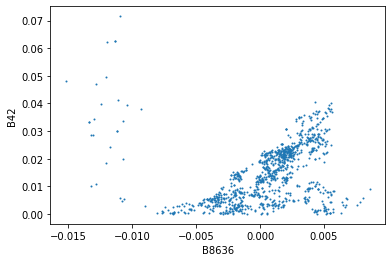

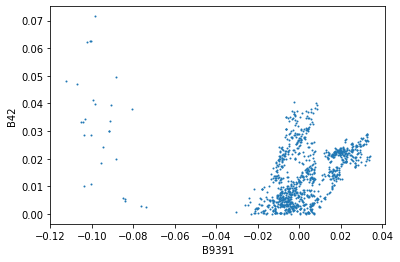

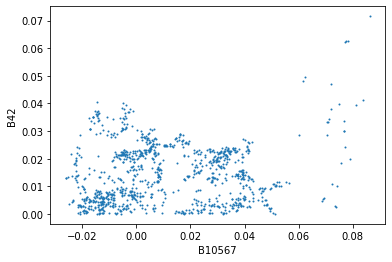

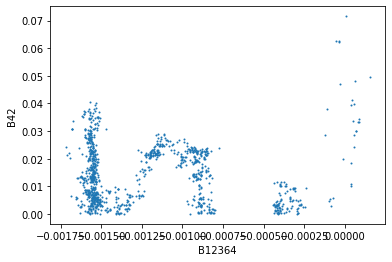

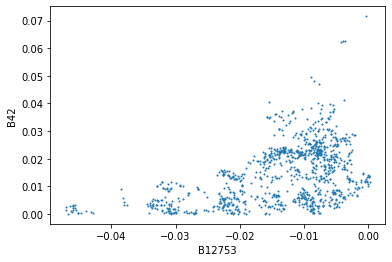

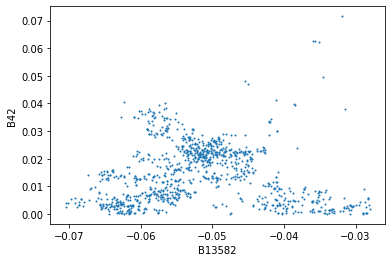

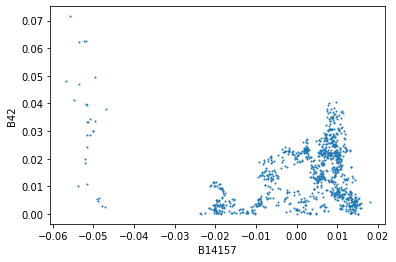

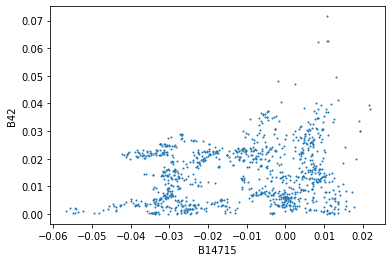

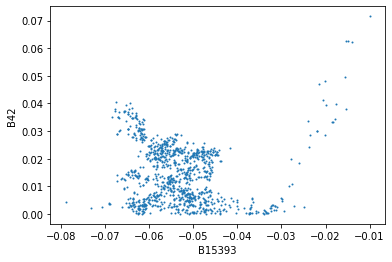

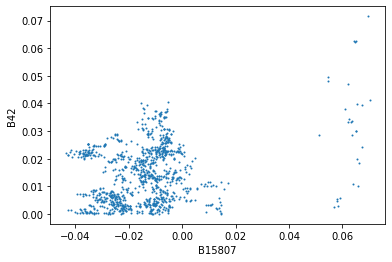

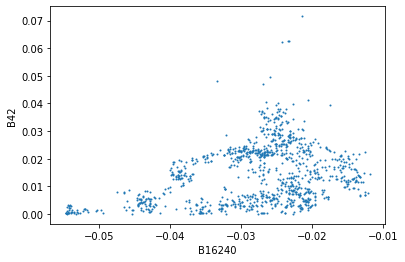

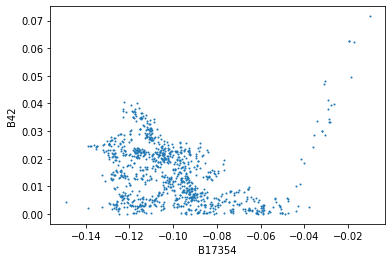

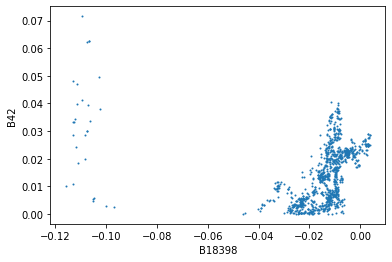

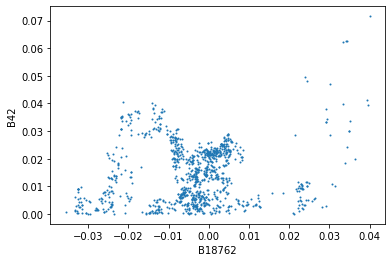

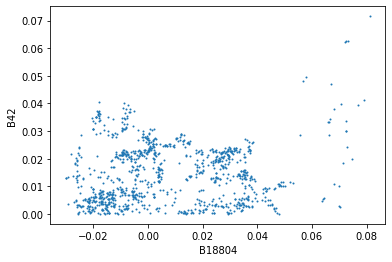

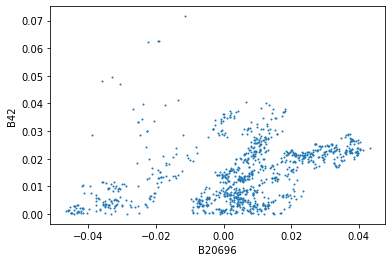

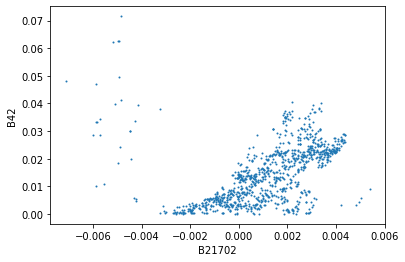

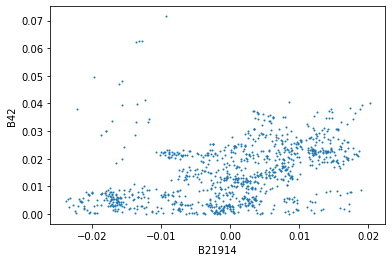

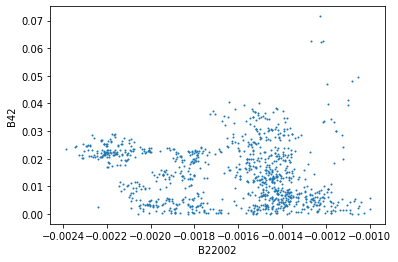

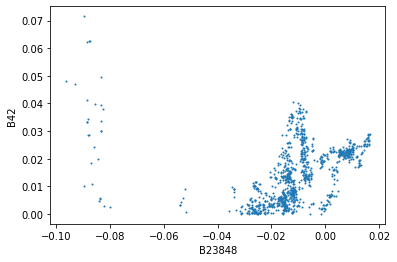

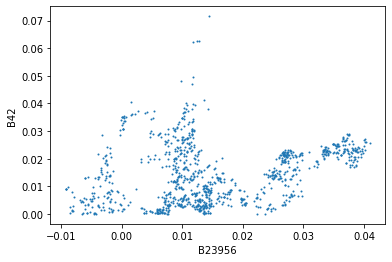

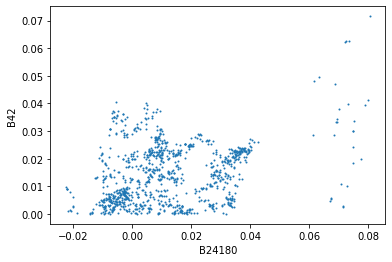

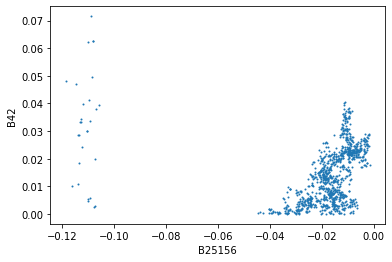

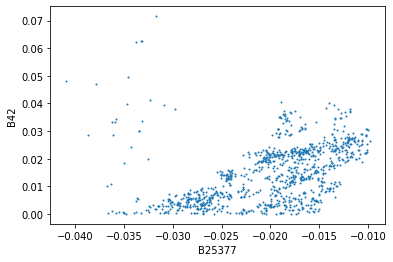

In [ ]:
print(f'Plot of {fund} return vs predictors w/ high t-stats')
for col in selected_cols:
    plt.scatter(dataX[col], dataY, s=1)
    plt.xlabel(col)
    plt.ylabel(fund)
    plt.show()

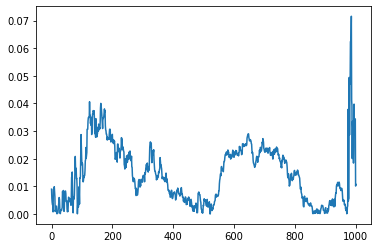

In [ ]:
dataY.plot()
plt.show()

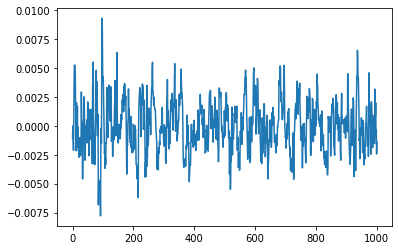

In [ ]:
res.resid.plot()
plt.show()

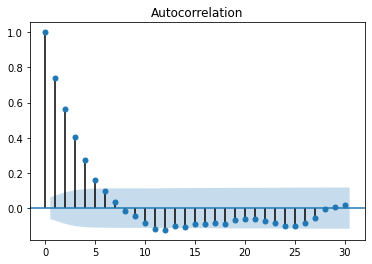

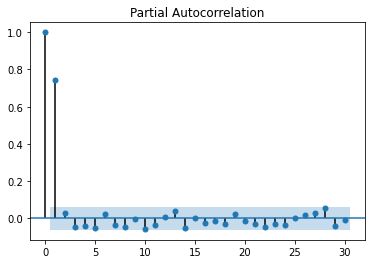

In [ ]:
# results suggest AR(1) process for residuals
resid = res.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(resid, lags=30)
plt.show()

## Regression forecast of B42 fund return using previous day returns

Now, a cross-sectional analysis of B42 is completed, via regression with excess returns of other funds day by day. One may question: does historical time series of the fund predict future movements? Specifically, does previous returns snapshot of the entire fund space provide information on how the fund will perform today? Results indicate affirmative -- following model simplification procedure described above, this time with a $t$-statistics threshold of 0.6, t-return of B42 is found to correlate with t-1-returns of 49 other funds, giving an adjusted R-squared of $94.2\%$.

In [ ]:
# return regression
fund = excess_return_selected.columns[0]
return_data = excess_return_selected.copy()
dataX = return_data.iloc[:-1]
dataY = return_data[fund][1:]
dataX.reset_index(drop=True, inplace=True)
dataY.reset_index(drop=True, inplace=True)

n_data = int(dataX.shape[0] * 0.7)
trainX, trainY = dataX.iloc[:n_data], dataY.iloc[:n_data]
testX, testY = dataX.iloc[n_data:], dataY.iloc[n_data:]
n_data, dataX.shape[0]

(700, 1001)

In [ ]:
# fit regression
trainX = sm.add_constant(trainX)
mod = sm.OLS(trainY, trainX)
res = mod.fit()
print('fund:', fund)
res.summary()

fund: B42


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    B42   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     129.0
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           2.78e-13
Time:                        20:49:07   Log-Likelihood:                 5299.1
No. Observations:                 700   AIC:                            -9226.
Df Residuals:                      14   BIC:                            -6104.
Df Model:                         685                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4497      3.663     -0.396      0.698      -9.306       6.407
B42           14.3259     38.129      0.376      0.713     -67.453      96.105
B45            2.5199     15.140      0.166      0.870     -29.952      34.992
B209          23.9693     61.850      0.388      0.704    -108.687     156.625
B241           1.0433      2.871      0.363      0.722      -5.114       7.201
B350           5.7865     19.212      0.301      0.768     -35.420      46.993
B356          -7.5772     14.153     -0.535      0.601     -37.932      22.778
B373          12.4414     46.779      0.266      0.794     -87.890     112.773
B382         -10.6190     33.200     -0.320      0.754     -81.826      60.588
B387          -1.6191      7.430     -0.218      0.831     -17.554      14.316
B392         -13.2020     37.564     -0.351      0.730     -93.769      67.365
B397          12.9034     31.861      0.405      0.692     -55.433      81.239
B404           6.2299     17.721      0.352      0.730     -31.778      44.238
B405           0.5073      2.185      0.232      0.820      -4.180       5.194
B406          -4.2236     10.566     -0.400      0.695     -26.886      18.439
B635           9.5660     34.258      0.279      0.784     -63.909      83.041
B656           5.1831     12.682      0.409      0.689     -22.017      32.383
B671          -8.5386     29.607     -0.288      0.777     -72.039      54.962
B687          -9.1741     18.138     -0.506      0.621     -48.076      29.728
B701          26.3541     71.143      0.370      0.717    -126.232     178.940
B762           4.8994      9.398      0.521      0.610     -15.257      25.056
B800           0.6550      7.736      0.085      0.934     -15.937      17.247
B816         -19.2768     45.329     -0.425      0.677    -116.498      77.944
B844         -12.2738     35.473     -0.346      0.734     -88.355      63.808
B850           9.0997     34.063      0.267      0.793     -63.958      82.157
B851         -10.6851     32.203     -0.332      0.745     -79.755      58.384
B896          -0.6570     11.490     -0.057      0.955     -25.300      23.986
B901         -17.8408     38.300     -0.466      0.649     -99.986      64.304
B936          -4.7382     17.560     -0.270      0.791     -42.400      32.924
B938          -6.7428     20.494     -0.329      0.747     -50.698      37.213
B948           3.0071      7.893      0.381      0.709     -13.922      19.936
B1009         -0.0213      4.275     -0.005      0.996      -9.191       9.148
B1013         -8.6161     28.781     -0.299      0.769     -70.346      53.114
B1028          0.7909      1.295      0.611      0.551      -1.987       3.568
B1060        -33.3259     74.819     -0.445      0.663    -193.796     127.144
B1061          4.8486      8.467      0.573      0.576     -13.312      23.010
B1

In [ ]:
tvalues_thres = 0.6
while len(res.tvalues[res.tvalues.abs() < tvalues_thres].index) > 1:
    selected_cols = list(res.tvalues[res.tvalues.abs() > tvalues_thres].index)
    trainX = trainX[selected_cols]
    trainX = sm.add_constant(trainX)
    mod = sm.OLS(trainY, trainX)
    res = mod.fit()
    print('fund:', fund)
    print(res.summary())
selected_cols[:10]

fund: B42
                            OLS Regression Results                            
Dep. Variable:                    B42   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     171.8
Date:                Wed, 29 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:49:08   Log-Likelihood:                 3259.8
No. Observations:                 700   AIC:                            -6388.
Df Residuals:                     634   BIC:                            -6087.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0087      0.013     -0.67

['const',
 'B1028',
 'B1109',
 'B2335',
 'B3987',
 'B5093',
 'B5854',
 'B5876',
 'B6041',
 'B6387']

Test RMSE: 0.0393


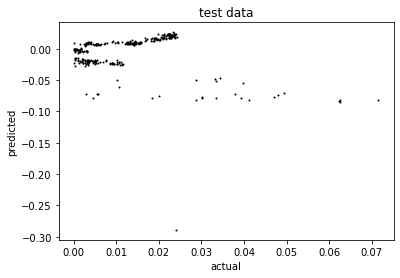

In [ ]:
# make prediction
testX = sm.add_constant(testX)[selected_cols]
yhat = res.predict(testX)
yact = testY
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
# plt.xlim(-0.05, 0.05)
# plt.ylim(-0.05, 0.05)
plt.show()

## LSTM forecast of B42 fund return using historical returns

What about a wider historical window? A one-day window may not suffice, and one would want to feed a wider window into the model, in scale of months. Long Short-Term Memory comes into play. Here, we choose to feed a 3-month backward historical window of B42 and its associated 49 other funds into a LSTM single-layer 200-node network, with its prediction results as follows. A linearity is observed, which suggests LSTM can be of use in predicting from historical data.

In [ ]:
excess_return_selected.head(), selected_cols[:10]

(                 B42       B45      B209  ...    B26022    B26042    B26061
 Date                                      ...                              
 2012-05-13  0.008976 -0.003126 -0.025190  ... -0.021569 -0.009263 -0.017416
 2012-05-14  0.005727 -0.004066 -0.025916  ... -0.024258 -0.013597 -0.016861
 2012-05-15  0.004217 -0.004593 -0.027445  ... -0.024894 -0.010078 -0.017289
 2012-05-16  0.003374 -0.005164 -0.028629  ... -0.026197 -0.010316 -0.017340
 2012-05-17  0.003109 -0.006923 -0.029560  ... -0.027500 -0.010619 -0.018322
 
 [5 rows x 866 columns],
 ['const',
  'B1028',
  'B1109',
  'B2335',
  'B3987',
  'B5093',
  'B5854',
  'B5876',
  'B6041',
  'B6387'])

In [ ]:
fund = excess_return_selected.columns[0]
cols = [fund] + selected_cols[1:]
return_data = excess_return_selected[cols].copy()

def create_dataset(data, y_col, look_back=1, look_forward=1):
    dataX = []
    dataY = []
    for i in range(look_back, data.shape[0]-look_forward):
        dataX.append(data.iloc[i-look_back:i,:].values)
        dataY.append(data[y_col].iloc[i:i+look_forward].values)
    dataX, dataY = np.array(dataX), np.array(dataY)
    return dataX, dataY

dataX, dataY = create_dataset(return_data, fund, 63, 1)
dataX.shape, dataY.shape

((938, 63, 50), (938, 1))

In [ ]:
n_data = int(dataX.shape[0] * 0.7)
trainX, trainY = dataX[:n_data], dataY[:n_data]
testX, testY = dataX[n_data:], dataY[n_data:]
n_data, dataX.shape[0]

(656, 938)

In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
30/30 [==============================] - 6s 125ms/step - loss: 3.6087e-04 - val_loss: 7.5549e-05
Epoch 2/10
30/30 [==============================] - 3s 104ms/step - loss: 2.7568e-05 - val_loss: 2.3698e-05
Epoch 3/10
30/30 [==============================] - 3s 107ms/step - loss: 2.0835e-05 - val_loss: 5.0242e-05
Epoch 4/10
30/30 [==============================] - 3s 106ms/step - loss: 1.5723e-05 - val_loss: 5.6750e-05
Epoch 5/10
30/30 [==============================] - 3s 102ms/step - loss: 1.3025e-05 - val_loss: 7.2056e-05
Epoch 6/10
30/30 [==============================] - 3s 105ms/step - loss: 1.1680e-05 - val_loss: 7.8009e-05
Epoch 7/10
30/30 [==============================] - 3s 105ms/step - loss: 1.0065e-05 - val_loss: 8.2211e-05
Epoch 8/10
30/30 [==============================] - 3s 104ms/step - loss: 1.1674e-05 - val_loss: 5.3744e-05
Epoch 9/10
30/30 [==============================] - 3s 103ms/step - loss: 1.0725e-05 - val_loss: 2.6676e-05
Epoch 10/10
30/30 [=========

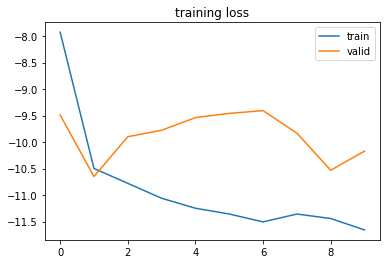

In [ ]:
# plot history
plt.plot(np.log(history.history['loss']), label='train')
plt.plot(np.log(history.history['val_loss']), label='valid')
plt.title('training loss')
plt.legend()
plt.show()

Test RMSE: 0.0033


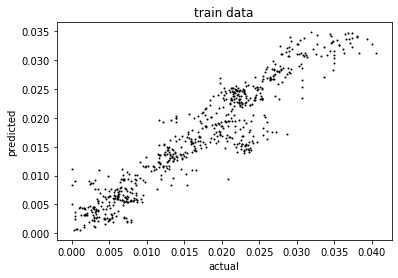

In [ ]:
# make a prediction
yhat = model.predict(trainX)
yhat = yhat.reshape(-1)
yact = trainY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('train data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0386


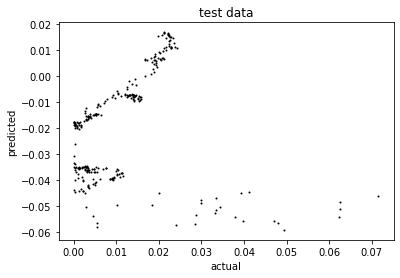

In [ ]:
# make prediction
yhat = model.predict(testX)
yhat = yhat.reshape(-1)
yact = testY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0054


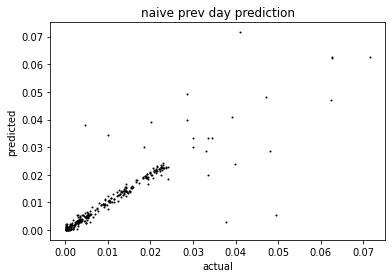

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact[1:], yact[:-1]))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact[1:], yact[:-1], s=1, c='k')
plt.title('naive prev day prediction')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Baseline Models

Baseline models forecast excess returns using the time series data only, but excluding alternative data. Models here seek to replicate previous groups' results, against which our later alt. data models are benchmarked.

Since not every mutual fund exists for the entire period spanning 2000 to 2021, there is a large number of missing values in the time-series parquet dataset. N/A values are removed, and we note that all (non-N/A) numeric values are consecutive for each fund.

A performance measure window of three years is used, meaning we view every three years of excess returns as a cycle. Given this, we remove funds with an excess return history of less than three years.

The dataset is split into a training and testing set, with the splitting threshold on 2020-06-30. This follows the conventions of previous work, as in dev\_prediction.ipynb. Specifically, the sampling parameters applied to MF\_LargeCap\_ExcessReturn\_3Y.parquet to generate our training and testing set are as follows:

* feat_window = 90
* pm_window = 3
* lb_window = int(3 * pm_window * 365.25) + 1
* sample_window = 30
* test_start_date = '2020-06-30'

In [18]:
#### adopted from dev_prediction.ipynb

# window length between two consecutive features: number of days
feat_window = 90
# performance measures window: number of years
pm_window = 3
lb_window = int(3 * pm_window * 365.25) + 1
# window length between training samples: number of days
sample_window = 30
# test period start
test_start_date = '2020-06-30'

def prepare_data(data):

    data_dict = {ticker: data[ticker].dropna() for ticker in data.columns}
    
    tickers_to_remove = []
    
    label_dict = {}
    for ticker, series in tqdm(data_dict.items()):
        if series.isna().sum() == series.shape[0]:
            tickers_to_remove += [ticker]
            continue

        last_date = series.index[-1] - relativedelta(years=pm_window)
        if last_date <= series.index[0]:
            tickers_to_remove.append(ticker)
            continue

        index = series.loc[:series.index[-1] - relativedelta(years=pm_window)].index
        label_dict[ticker] = pd.Series([
            series[date + relativedelta(years=pm_window)] for date in index
        ], index=index)
        
    _ = [data_dict.pop(ticker) for ticker in tickers_to_remove]

    return data_dict, label_dict

def timeseries_dataset(data_dict, label_dict):

    tickers = list(data_dict.keys())

    train_data = []
    train_labels = []

    test_data = []
    test_labels = []

    # test start date
    checkpoint = datetime.strptime(test_start_date, '%Y-%m-%d') - relativedelta(years=pm_window)

    for ticker in tqdm(tickers):    
        label = label_dict[ticker]
        if label.shape[0] == 0:
            continue
        ts = data_dict[ticker].loc[:label.index[-1]]

        indices = [np.arange(i, i+lb_window, feat_window) for i in range(0, ts.shape[0] - lb_window + 1, sample_window)]
        
        temp_data = np.array([ts.iloc[sub_indices].values for sub_indices in indices])
        if temp_data.shape[0] == 0:
            continue
        temp_labels = np.array([label.loc[ts.index[sub_indices[-1]]] for sub_indices in indices])
        
        train_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] <= checkpoint]
        test_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] > checkpoint]
        
        train_data += [temp_data[train_indices]] 
        train_labels += [temp_labels[train_indices]]
        
        test_data += [temp_data[test_indices]] 
        test_labels += [temp_labels[test_indices]]

    trainX = np.concatenate(train_data)
    trainY = np.concatenate(train_labels)

    testX = np.concatenate(test_data)
    testY = np.concatenate(test_labels)

    trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
    trainY = trainY.reshape(trainY.shape[0], 1)

    testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
    testY = testY.reshape(testY.shape[0], 1)

    return trainX, trainY, testX, testY

In [19]:
data_dict, label_dict = prepare_data(excess_return)

100%|██████████| 1330/1330 [03:58<00:00,  5.59it/s]


In [ ]:
trainX, trainY, testX, testY = timeseries_dataset(data_dict, label_dict)
trainX.shape, trainY.shape, testX.shape, testY.shape

100%|██████████| 1130/1130 [00:11<00:00, 101.40it/s]


((47052, 1, 37), (47052, 1), (10479, 1, 37), (10479, 1))

In [ ]:
# def timeseries_dataset(data, look_back=1, look_forward=1):
#     dataX = []
#     dataY = []
#     for k in data.columns:
#         data_k = data[k].dropna()
#         for i in range(look_back, len(data_k)-look_forward, look_back):
#             dataX.append(data_k.iloc[i-look_back:i].values)
#             dataY.append(data_k.iloc[i:i+look_forward].values)
#     dataX, dataY = np.array(dataX).reshape(-1, 1, look_back), np.array(dataY)
#     return dataX, dataY

# look_back = 63
# dataX, dataY = timeseries_dataset(excess_return, look_back, 1)
# dataX.shape, dataY.shape

In [ ]:
# n_data = int(dataX.shape[0] * 0.7)
# trainX, trainY = dataX[:n_data], dataY[:n_data]
# testX, testY = dataX[n_data:], dataY[n_data:]
# n_data, dataX.shape[0]

## Baseline 1: LSTM model with only time series

Long Short Term Memory (LSTM) network is a recurrent neural network capable of learning sequenctial dependencies in sequence prediction problems. Unlike standard feedforward neural networks, LSTM has feedback connections, which process not only individual data points but also the entire data sequences. We use a single-layer 200-node LSTM model on time-series alone, which serve as one of our baseline models, against which our later alternative data models are benchmarked.

In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
2118/2118 [==============================] - 13s 5ms/step - loss: 0.0011 - val_loss: 9.0874e-04
Epoch 2/10
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0010 - val_loss: 8.9579e-04
Epoch 3/10
2118/2118 [==============================] - 10s 4ms/step - loss: 0.0010 - val_loss: 8.9690e-04
Epoch 4/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.9930e-04 - val_loss: 9.2913e-04
Epoch 5/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.8586e-04 - val_loss: 9.4180e-04
Epoch 6/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.8142e-04 - val_loss: 9.2926e-04
Epoch 7/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.7113e-04 - val_loss: 9.3365e-04
Epoch 8/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.6541e-04 - val_loss: 9.5367e-04
Epoch 9/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.5987e-04 - val_loss: 9.8509e-04
Epoch 10/10
2

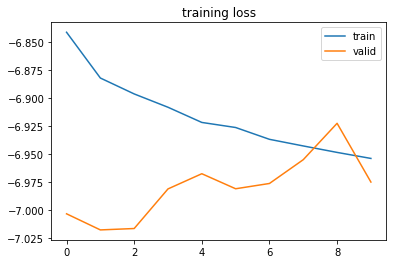

In [ ]:
# plot history
plt.plot(np.log(history.history['loss']), label='train')
plt.plot(np.log(history.history['val_loss']), label='valid')
plt.title('training loss')
plt.legend()
plt.show()

Train RMSE: 0.0307


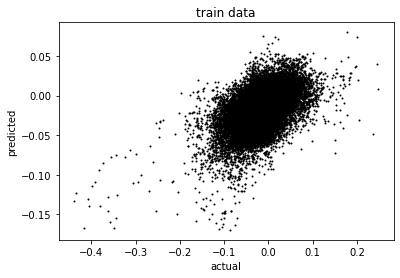

In [ ]:
# make a prediction
yhat = model.predict(trainX)
yhat = yhat.reshape(-1)
yact = trainY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Train RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('train data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0695


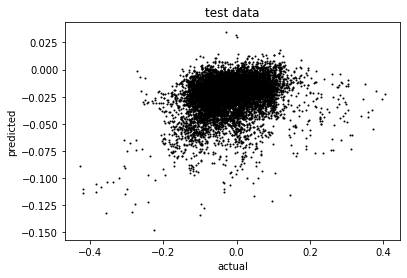

In [ ]:
# make prediction
yhat = model.predict(testX)
yhat = yhat.reshape(-1)
yact = testY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

## Baseline 1: LSTM model with only time series -- different architectures

- Codes here test the forecast results varying model architectures, such as number of layers and nodes. There appears to be no significant improvements over our baseline single-layer 200-node network. Interested users may run codes below to verify -- but as this is very time-consuming, we intentionally leave them commented.

In [ ]:
# model_lstm1 = Sequential()
# model_lstm1.add(LSTM(200, input_shape=(trainX.shape[1], trainX.shape[2])))
# model_lstm1.add(Dense(200))
# model_lstm1.add(Dense(trainY.shape[1]))
# model_lstm1.compile(loss='mse', optimizer='adam')
# history = model_lstm1.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_lstm1.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_lstm2 = Sequential()
# model_lstm2.add(LSTM(200, input_shape=(trainX.shape[1], trainX.shape[2])))
# model_lstm2.add(Dense(200))
# model_lstm2.add(Dense(200))
# model_lstm2.add(Dense(trainY.shape[1]))
# model_lstm2.compile(loss='mse', optimizer='adam')
# history = model_lstm2.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_lstm2.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_lstm3 = Sequential()
# model_lstm3.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
# model_lstm3.add(Dense(100))
# model_lstm3.add(Dense(100))
# model_lstm3.add(Dense(trainY.shape[1]))
# model_lstm3.compile(loss='mse', optimizer='adam')
# history = model_lstm3.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_lstm3.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_lstm4 = Sequential()
# model_lstm4.add(LSTM(400, input_shape=(trainX.shape[1], trainX.shape[2])))
# model_lstm4.add(Dense(trainY.shape[1]))
# model_lstm4.compile(loss='mse', optimizer='adam')
# history = model_lstm4.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_lstm4.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_lstm5 = Sequential()
# model_lstm5.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
# model_lstm5.add(Dense(trainY.shape[1]))
# model_lstm5.compile(loss='mse', optimizer='adam')
# history = model_lstm5.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_lstm5.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

## Baseline 2: FNN model with only time series

Feedforward Neural Network (FNN) is an artificial neural network where the connections between nodes do not form a cycle, with the goal to approximate some function $f^\ast$ by defining a map $y=f(x;\theta)$ and learning parameters $\theta$ that result in the best function approximation. Learning process is achieved via gradient descent techniques (and many of its variations) and training loss is typified by mean-squared error. As with the LSTM network, here we adopt a 200-node single layer.

In [ ]:
model = Sequential()
model.add(Dense(200))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0012 - val_loss: 9.6825e-04
Epoch 2/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.5626e-04
Epoch 3/10
2118/2118 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.7238e-04
Epoch 4/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.5575e-04
Epoch 5/10
2118/2118 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.3757e-04
Epoch 6/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.3188e-04
Epoch 7/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.2968e-04
Epoch 8/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.5316e-04
Epoch 9/10
2118/2118 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.4227e-04
Epoch 10/10
2118/2118 [=======================

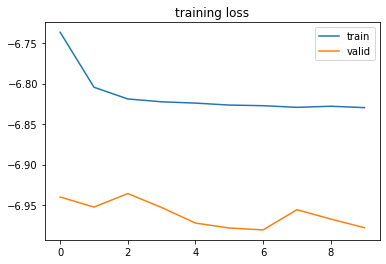

In [ ]:
# plot history
plt.plot(np.log(history.history['loss']), label='train')
plt.plot(np.log(history.history['val_loss']), label='valid')
plt.title('training loss')
plt.legend()
plt.show()

Train RMSE: 0.0325


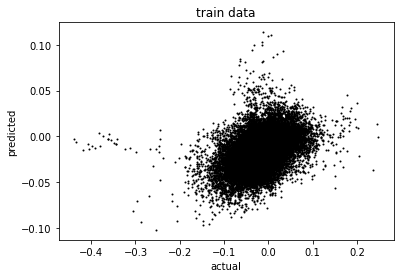

In [ ]:
# make a prediction
yhat = model.predict(trainX)
yhat = yhat.reshape(-1)
yact = trainY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Train RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('train data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0693


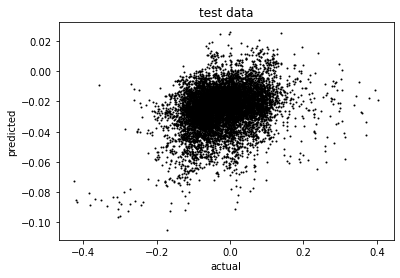

In [ ]:
# make prediction
yhat = model.predict(testX)
yhat = yhat.reshape(-1)
yact = testY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

## Baseline 2: FNN model with only time series -- different architectures

- Codes here test the forecast results varying model architectures, such as number of layers and nodes. There appears to be no significant improvements over our baseline single-layer 200-node network. Interested users may run codes below to verify -- but as this is very time-consuming, we intentionally leave them commented.

In [ ]:
# model_fnn1 = Sequential()
# model_fnn1.add(Dense(200))
# model_fnn1.add(Dense(200))
# model_fnn1.add(Dense(trainY.shape[1]))
# model_fnn1.compile(loss='mse', optimizer='adam')
# history = model_fnn1.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_fnn1.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_fnn2 = Sequential()
# model_fnn2.add(Dense(200))
# model_fnn2.add(Dense(200))
# model_fnn2.add(Dense(200))
# model_fnn2.add(Dense(trainY.shape[1]))
# model_fnn2.compile(loss='mse', optimizer='adam')
# history = model_fnn2.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_fnn2.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_fnn3 = Sequential()
# model_fnn3.add(Dense(100))
# model_fnn3.add(Dense(100))
# model_fnn3.add(Dense(trainY.shape[1]))
# model_fnn3.compile(loss='mse', optimizer='adam')
# history = model_fnn3.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_fnn3.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

In [ ]:
# model_fnn4 = Sequential()
# model_fnn4.add(Dense(100))
# model_fnn4.add(Dense(100))
# model_fnn4.add(Dense(100))
# model_fnn4.add(Dense(trainY.shape[1]))
# model_fnn4.compile(loss='mse', optimizer='adam')
# history = model_fnn4.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

# # make prediction
# yhat = model_fnn4.predict(testX)
# yhat = yhat.reshape(-1)
# yact = testY.reshape(-1)
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(yact, yhat))
# print('Test RMSE: %.4f' % rmse)
# # plot pred vs actual
# plt.scatter(yact, yhat, s=1, c='k')
# plt.title('test data')
# plt.xlabel('actual')
# plt.ylabel('predicted')
# plt.show()

## Naive previous-period forecast

- a no-brainer forecast assuming previous-period return predicts next-period return

Train RMSE: 0.0391


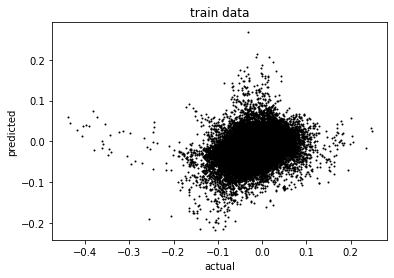

In [ ]:
# make prediction
yhat = trainX[:,0,-1]
yact = trainY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Train RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('train data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0609


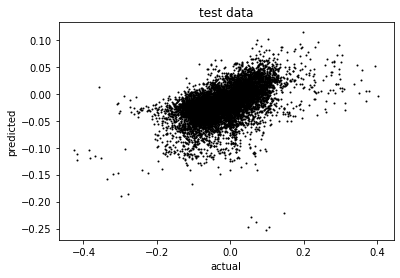

In [ ]:
# make prediction
yhat = testX[:,0,-1]
yact = testY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Alt. Data Models

Two models are proposed as follows, in an attempt to combine time-series and alternative data: (1) a simple FNN that merges time-series and alternative data, and (2) a separate architecture with two sub-networks -- LSTM for time-series and regression/feedforward network for alternative data. Respectively, we denote them AltFNN and LSTM-AltReg/FNN. Compared to our baselines, both achieve better prediction results, either graphically or via mean-squared error. Below, we discuss their associated rationales and the prediction outcomes. Regarding network architectures, all LSTM/FNNs in this section contain a 200-node single layer, and our aim here is to shape the prediction frameworks, rather than optimal network structures.


## AltFNN: FNN model with time series & alt. data

AltFNN concatenates the alternative features to time-series data, and feeds them altogether into an FNN network. More explicitly, the data construction goes as follows: for each mutual fund, (1) split the historical excess return time series into disjoint timeframes of $d_1$ days, according to parameters specified in Data Labeling; (2) attach to each timeframe identical one-hot encoded categorical features of the fund, of dimension $d_2$. As they are concatenated, the input matrix into FNN carries a dimension of $N \times (d_1+d_2)$. In our case, $d_1=37$ days and $d_2=3325$ is the sum of the numbers of existing values in all categorical features, including Administrator, Auditor and so on, and finally $N=47052$. We split training and testing set by a ratio of $0.7:0.3$. Reader may refer to function timeseries\_alt\_dataset() for the concatenation procedure.

In [13]:
for i in opt_people.columns:
    opt_people[i] = opt_people[i].replace(np.nan, 'none', regex=True)
labelencoder = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')
opt_people.head()

,Administrator,Advisor,Auditor,Custodian,Distributor,Manager History,Manager of Managers,Manager Ownership Level,Subadvised,Subadvisor,Superannuation
ASK_ID,,,,,,,,,,,
B42,"American Century Services, LLC",American Century Investment Management Inc,Deloitte & Touche LLP,State Street Bank & Trust Co,American Century Investment Sv Inc,[1999-11-30 -- 2005-02-28] James E. Stowers;[1...,No,none,No,none,No
B45,none,"BNY Mellon Investment Adviser, Inc.",Ernst & Young LLP,The Bank of New York Mellon,BNY Mellon Securities Corporation,[1997-07-22 -- 2004-10-05] Douglas D. Ramos;[1...,No,none,No,none,No
B50,"American Century Services, LLC;State Street Ba...",American Century Investment Management Inc,Pricewaterhousecoopers LLP,State Street Bank & Trust Co,American Century Investment Sv Inc,[2011-10-31 -- 2016-05-18] William Martin;[201...,No,Claudia Musat [$0 - None];Steven Rossi [$0 - N...,No,none,No
B56,J. P. Morgan Chase Bank NA,AQR Capital Management LLC,Pricewaterhousecoopers LLP,JPMorgan Chase Bank;State Street Bank And Trus...,ALPS Distributors Inc,[2016-12-14 -- 2019-12-20] Jacques A. Friedman...,No,none,No,none,No
B113,Commonwealth Fund Services Inc,CBOE Vest Financial LLC,"Cohen & Company, Ltd.",Fifth Third Bank,First Dominion Capital Corp,[2018-05-21 -- 2019-09-13] Rachel Ames;[2017-0...,No,Howard Rubin [$0 - None];Karan Sood [NA - FC I...,No,none,No


In [14]:
def one_hot(alt_data, col):
    i = alt_data[col]
    i_df = pd.DataFrame({col: i.tolist()})
    alt_data[col] = labelencoder.fit_transform(alt_data[col])
    enc_df = pd.DataFrame(enc.fit_transform(alt_data[[col]]).toarray())
    enc_df.index = i.index
    return enc_df

In [15]:
opt_people.columns

Index(['Administrator', 'Advisor', 'Auditor', 'Custodian', 'Distributor',
       'Manager History', 'Manager of Managers', 'Manager Ownership Level',
       'Subadvised', 'Subadvisor', 'Superannuation'],
      dtype='object')

In [16]:
def one_hot_dataset(alt_data):
    enc_df = pd.concat([one_hot(alt_data, col) for col in alt_data.columns], axis=1)
    enc_df.columns = list(range(len(enc_df.columns)))
    return enc_df

In [17]:
one_hot_opt_people = one_hot_dataset(opt_people)
one_hot_opt_people.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324
ASK_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
B45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
B50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
B56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
B113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [36]:
def timeseries_alt_dataset(data_dict, label_dict, one_hot_alt_data):

    tickers = list(data_dict.keys())

    train_data = []
    train_labels = []

    test_data = []
    test_labels = []

    # test start date
    checkpoint = datetime.strptime(test_start_date, '%Y-%m-%d') - relativedelta(years=pm_window)

    for ticker in tqdm(tickers):    
        label = label_dict[ticker]
        if label.shape[0] == 0:
            continue
        ts = data_dict[ticker].loc[:label.index[-1]]

        indices = [np.arange(i, i+lb_window, feat_window) for i in range(0, ts.shape[0] - lb_window + 1, sample_window)]
        
        temp_data = np.array([np.concatenate([ts.iloc[sub_indices].values, one_hot_alt_data.loc[ticker]]) for sub_indices in indices])
        if temp_data.shape[0] == 0:
            continue
        temp_labels = np.array([label.loc[ts.index[sub_indices[-1]]] for sub_indices in indices])
        
        train_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] <= checkpoint]
        test_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] > checkpoint]
        
        train_data += [temp_data[train_indices]] 
        train_labels += [temp_labels[train_indices]]
        
        test_data += [temp_data[test_indices]] 
        test_labels += [temp_labels[test_indices]]

    trainX = np.concatenate(train_data)
    trainY = np.concatenate(train_labels)

    testX = np.concatenate(test_data)
    testY = np.concatenate(test_labels)

    trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
    trainY = trainY.reshape(trainY.shape[0], 1)

    testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
    testY = testY.reshape(testY.shape[0], 1)

    return trainX, trainY, testX, testY

In [21]:
trainX, trainY, testX, testY = timeseries_alt_dataset(data_dict, label_dict, one_hot_opt_people)
trainX.shape, trainY.shape, testX.shape, testY.shape

100%|██████████| 1130/1130 [00:29<00:00, 37.94it/s]


((47052, 1, 3362), (47052, 1), (10479, 1, 3362), (10479, 1))

In [ ]:
# def timeseries_alt_dataset(data, one_hot_alt_data, look_back=1, look_forward=1):
#     dataX = []
#     dataY = []
#     for j, k in enumerate(data.columns):
#         data_k = data[k].dropna()
#         for i in range(look_back, len(data_k)-look_forward, look_back):
#             dataX.append(np.concatenate([data_k.iloc[i-look_back:i].values, one_hot_alt_data.iloc[j]]))
#             dataY.append(data_k.iloc[i:i+look_forward].values)
#     dataX, dataY = np.array(dataX).reshape(-1, 1, look_back+one_hot_alt_data.shape[1]), np.array(dataY)
#     return dataX, dataY

# look_back = 63
# dataX, dataY = timeseries_alt_dataset(excess_return, one_hot_opt_people, look_back, 1)
# dataX.shape, dataY.shape

In [ ]:
# n_data = int(dataX.shape[0] * 0.7)
# trainX, trainY = dataX[:n_data], dataY[:n_data]
# testX, testY = dataX[n_data:], dataY[n_data:]
# n_data, dataX.shape[0]

In [ ]:
model = Sequential()
model.add(Dense(200))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
2118/2118 [==============================] - 12s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8166e-04 - val_loss: 0.0012
Epoch 3/10
2118/2118 [==============================] - 11s 5ms/step - loss: 5.8520e-04 - val_loss: 0.0012
Epoch 4/10
2118/2118 [==============================] - 11s 5ms/step - loss: 5.9483e-04 - val_loss: 0.0012
Epoch 5/10
2118/2118 [==============================] - 11s 5ms/step - loss: 5.9421e-04 - val_loss: 0.0012
Epoch 6/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.9059e-04 - val_loss: 0.0013
Epoch 7/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.9252e-04 - val_loss: 0.0012
Epoch 8/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8523e-04 - val_loss: 0.0013
Epoch 9/10
2118/2118 [==============================] - 12s 5ms/step - loss: 5.8323e-04 - val_loss: 0.0013
Epoch 10/10
2118/2118 [==================

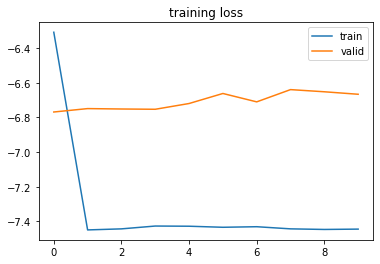

In [ ]:
# plot history
plt.plot(np.log(history.history['loss']), label='train')
plt.plot(np.log(history.history['val_loss']), label='valid')
plt.title('training loss')
plt.legend()
plt.show()

Train RMSE: 0.0252


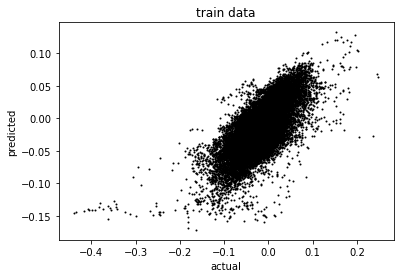

In [ ]:
# make a prediction
yhat = model.predict(trainX)
yhat = yhat.reshape(-1)
yact = trainY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Train RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('train data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

Test RMSE: 0.0594


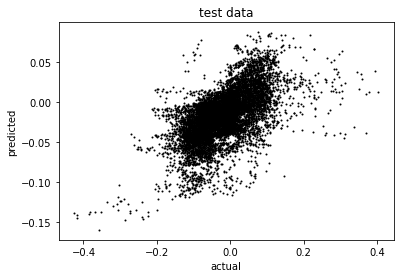

In [ ]:
# make prediction
yhat = model.predict(testX)
yhat = yhat.reshape(-1)
yact = testY.reshape(-1)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

## AltReg: Regression model for alt. data

In [22]:
def alt_dataset(data_dict, label_dict, one_hot_alt_data):

    tickers = list(data_dict.keys())

    mean_labels = {}

    for ticker in tqdm(tickers):    
        label = label_dict[ticker]
        if label.shape[0] == 0:
            continue
        ts = data_dict[ticker].loc[:label.index[-1]]

        indices = [np.arange(i, i+lb_window, feat_window) for i in range(0, ts.shape[0] - lb_window + 1, sample_window)]
        
        temp_data = np.array([np.concatenate([ts.iloc[sub_indices].values, one_hot_alt_data.loc[ticker]]) for sub_indices in indices])
        if temp_data.shape[0] == 0:
            continue
        temp_labels = np.array([label.loc[ts.index[sub_indices[-1]]] for sub_indices in indices])
        
        mean_labels[ticker] = temp_labels.mean()

    one_hot_alt_data_labeled = one_hot_alt_data.loc[list(mean_labels.keys())]
    one_hot_alt_data_labeled['Y'] = list(mean_labels.values())

    return one_hot_alt_data_labeled

In [23]:
one_hot_opt_people_labeled = alt_dataset(data_dict, label_dict, one_hot_opt_people)
one_hot_opt_people_labeled.head()

100%|██████████| 1130/1130 [00:37<00:00, 30.06it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,Y
ASK_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.026332
B45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.019656
B241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.027040
B350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.056756
B356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.035328


In [30]:
# regression of 3y forward return vs alt data
dataX = one_hot_opt_people_labeled.drop('Y', axis=1)
dataY = one_hot_opt_people_labeled['Y']
dataX.reset_index(drop=True, inplace=True)
dataY.reset_index(drop=True, inplace=True)

n_data = int(dataX.shape[0] * 0.7)
trainX, trainY = dataX.iloc[:n_data], dataY.iloc[:n_data]
testX, testY = dataX.iloc[n_data:], dataY.iloc[n_data:]
n_data, dataX.shape[0]

(581, 831)

In [31]:
# fit regression
trainX = sm.add_constant(trainX)
model_alt = sm.OLS(trainY, trainX)
model_alt = model_alt.fit()
model_alt.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                 -3.407
Method:                 Least Squares   F-statistic:                    0.2242
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.988
Time:                        03:23:04   Log-Likelihood:                 2290.8
No. Observations:                 581   AIC:                            -3424.
Df Residuals:                       2   BIC:                            -896.4
Df Model:                         578                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0153      0.022     -0.705      0.554      -0.108       0.078
1             -0.0043      0.009     -0.480      0.678      -0.043       0.034
2             -0.0115      0.013     -0.902      0.462      -0.066       0.043
3           4.892e-05      0.009      0.005      0.996      -0.040       0.040
4           1.145e-17   2.23e-17      0.514      0.658   -8.44e-17    1.07e-16
5           -1.25e-17   4.84e-17     -0.258      0.820   -2.21e-16    1.96e-16
6             -0.0036      0.011     -0.316      0.782      -0.052       0.045
7              0.0044      0.007      0.594      0.613      -0.027       0.036
8          -1.034e-18   6.01e-17     -0.017      0.988    -2.6e-16    2.57e-16
9              0.0061      0.010      0.613      0.603      -0.037       0.049
10          2.308e-17   6.02e-17      0.383      0.738   -2.36e-16    2.82e-16
11         -2.443e-19   1.43e-17     -0.017      0.988   -6.18e-17    6.13e-17
12          1.926e-19   9.18e-18      0.021      0.985   -3.93e-17    3.97e-17
13            -0.0161      0.016     -1.019      0.416      -0.084       0.052
14             0.0009      0.020      0.044      0.969      -0.086       0.088
15             0.0086      0.015      0.569      0.627      -0.057       0.074
16             0.0053      0.017      0.318      0.781      -0.067       0.077
17            -0.0026      0.030     -0.088      0.938      -0.130       0.125
18            -0.0002      0.012     -0.018      0.987      -0.052       0.052
19             0.0009      0.013      0.070      0.951      -0.056       0.058
20          5.271e-18   2.03e-17      0.260      0.819   -8.21e-17    9.26e-17
21         -1.884e-17   3.53e-17     -0.534      0.647   -1.71e-16    1.33e-16
22             0.0020      0.015      0.136      0.904      -0.061       0.065
23            -0.0163      0.013     -1.213      0.349      -0.074       0.042
24             0.0031      0.011      0.281      0.805      -0.044       0.050
25             0.0029      0.012      0.232      0.838      -0.051       0.056
26         -1.072e-17   3.98e-17     -0.269      0.813   -1.82e-16     1.6e-16
27             0.0025      0.015      0.167      0.883      -0.061       0.066
28           8.88e-06      0.009      0.001      0.999      -0.037       0.037
29            -0.0066      0.013     -0.509      0.661      -0.062       0.049
30            -0.0051      0.012     -0.417      0.717      -0.058       0.048
31             0.0020      0.010      0.191      0.866      -0.043       0.047
32            -0.0004      0.010     -0.042      0.970      -0.045       0.044
33             0.0033      0.022      0.151      0.894      -0.090       0.096
34            -0.0035      0.017     -0.212      0.852      -0.075       0.068
35            -0.0004      0.013     -0.030      0.979      -0.057       0.056
36

Test RMSE: 0.0396


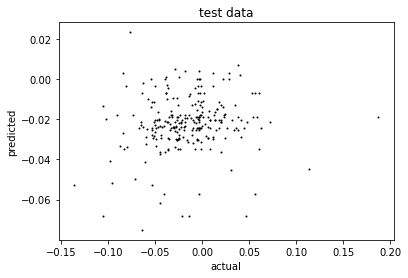

In [32]:
# make prediction
testX = sm.add_constant(testX)
yhat = model_alt.predict(testX)
yact = testY
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

## LSTM-AltReg: LSTM model with time series & alt. data

LSTM-AltReg extends our baseline LSTM model, by appending to the network a regression predictor $y_1$ for correcting the LSTM forecasts $y_2$, via a linear weight adjustment $w \in [0,1]$, with the final output given by $(1-w)y_1+wy_2$. Here, we treat time-series and alternative data on equal footing, for ease of implementation. Should user desire time-series data carry a more important role, a constraint on $w$ may be applied, for instance, $w \in [0.5,1]$. For the regression, the mean historical excess returns are regressed against the one-hot encoded categorical features, of dimension $d=3325$. Each fund, carrying its idiosyncratic alternative features, therefore gets mapped to a single mean excess return. Note that such sparse regression can be dangerous, since the number of samples $N$, in our case, number of mutual funds, is comparable to the number of one-hot features $d$. A consequence is that $t$-statistics of the regression coefficients may be small, and forecasts can carry large error margins. Future research may look into over-sampling techniques, such as SMOTE, to artificially produce more samples to improve statistical significance of coefficients. Regarding the last combining component of LSTM-AltReg, we resort to the simplest solution -- linear combination of $y_1$ and $y_2$. While the results demonstrated by this method are already very promising, we suggest future work looks into possibilities of replacing it with FNN or more sophisticated structures.

We sought the optimal combination of $y_1$ and $y_2$ based on the training dataset, by minimizing the loss $L=1/2N \sum (\hat{y}-y)^2$, where $\hat{y}=(1-w)y_1+wy_2$ is the averaged output and $y$ is the training label. From the training dataset, we obtained $w=0.22$, and for comparison, we also looked at $w=0.50$, i.e. a simple average of $y_1$ and $y_2$.

In [37]:
trainX, trainY, testX, testY = timeseries_alt_dataset(data_dict, label_dict, one_hot_opt_people)
trainX.shape, trainY.shape, testX.shape, testY.shape

100%|██████████| 1130/1130 [00:28<00:00, 39.00it/s]


((47052, 1, 3362), (47052, 1), (10479, 1, 3362), (10479, 1))

In [38]:
alt_dim = one_hot_opt_people.shape[1]
trainX_ts, testX_ts = trainX[:,:,:-alt_dim], testX[:,:,:-alt_dim]
trainX_alt, testX_alt = trainX[:,:,-alt_dim:], testX[:,:,-alt_dim:]
trainX_ts.shape, testX_ts.shape, trainX_alt.shape, testX_alt.shape

((47052, 1, 37), (10479, 1, 37), (47052, 1, 3325), (10479, 1, 3325))

In [26]:
model_ts = Sequential()
model_ts.add(LSTM(200, input_shape=(trainX_ts.shape[1], trainX_ts.shape[2])))
model_ts.add(Dense(trainY.shape[1]))
model_ts.compile(loss='mse', optimizer='adam')
history_ts = model_ts.fit(trainX_ts, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
2118/2118 [==============================] - 13s 5ms/step - loss: 0.0011 - val_loss: 9.2867e-04
Epoch 2/10
2118/2118 [==============================] - 12s 6ms/step - loss: 0.0010 - val_loss: 9.2560e-04
Epoch 3/10
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0010 - val_loss: 9.2987e-04
Epoch 4/10
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0010 - val_loss: 9.1217e-04
Epoch 5/10
2118/2118 [==============================] - 11s 5ms/step - loss: 9.9437e-04 - val_loss: 9.2989e-04
Epoch 6/10
2118/2118 [==============================] - 11s 5ms/step - loss: 9.8329e-04 - val_loss: 9.1124e-04
Epoch 7/10
2118/2118 [==============================] - 10s 5ms/step - loss: 9.7571e-04 - val_loss: 9.4403e-04
Epoch 8/10
2118/2118 [==============================] - 12s 6ms/step - loss: 9.6960e-04 - val_loss: 9.3714e-04
Epoch 9/10
2118/2118 [==============================] - 11s 5ms/step - loss: 9.6133e-04 - val_loss: 9.1493e-04
Epoch 10/10
2118/

In [27]:
trainX_alt = sm.add_constant(trainX_alt.reshape(trainX_alt.shape[0],-1))
testX_alt = sm.add_constant(testX_alt.reshape(testX_alt.shape[0],-1))

### Weight $w = 0.5$

In [28]:
w = 0.5

In [39]:
yhat_ts = model_ts.predict(testX_ts).reshape(-1)
yhat_alt = model_alt.predict(testX_alt).reshape(-1)
yhat = w*yhat_ts+(1-w)*yhat_alt
yact = testY.reshape(-1)

Test RMSE: 0.0608


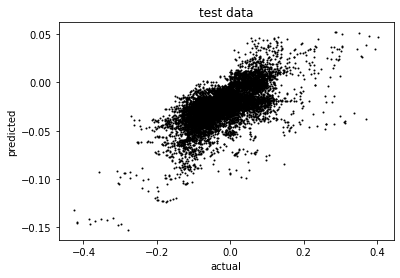

In [40]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

### Weight $w = \text{Optimal}$

In [41]:
yhat_ts = model_ts.predict(trainX_ts).reshape(-1)
yhat_alt = model_alt.predict(trainX_alt).reshape(-1)
yact = trainY.reshape(-1)
w = sum((yact-yhat_alt)*(yhat_ts-yhat_alt))/sum((yhat_ts-yhat_alt)**2)
w

0.4376851379971061

In [42]:
yhat_ts = model_ts.predict(testX_ts).reshape(-1)
yhat_alt = model_alt.predict(testX_alt).reshape(-1)
yhat = w*yhat_ts+(1-w)*yhat_alt
yact = testY.reshape(-1)

Test RMSE: 0.0598


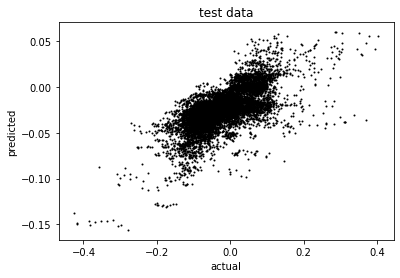

In [43]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual　
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

## LSTM-AltFNN: LSTM model with time series & alt. data

Now, we slightly modify LSTM-AltReg -- for alternative data, we replace the regression predictor with an AltFNN, our first model, hence the name LSTM-AltFNN. Similarly, we combine the two forecasts $y_1$ and $y_2$ by a linear weight $w$. Note that we have a duplication of time-series data here, in order to address the previous observation that time-series carry less important weight than alternative data.

Prediction results exhibit a clean linearity, meaning the model predictions correlate with the actual values. For the statistics, training dataset gives an RMSE of $0.0230$ while the testing dataset gives an RMSE of $0.0575$. This model returns the lowest out-of-sample RMSE among all models attempted, which nicely concludes our project.

In [44]:
model_alt = Sequential()
model_alt.add(Dense(200))
model_alt.add(Dense(1))
model_alt.compile(loss='mse', optimizer='adam')
history_alt = model_alt.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
2118/2118 [==============================] - 13s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 2/10
2118/2118 [==============================] - 13s 6ms/step - loss: 5.7880e-04 - val_loss: 0.0012
Epoch 3/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8610e-04 - val_loss: 0.0013
Epoch 4/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8875e-04 - val_loss: 0.0012
Epoch 5/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.9435e-04 - val_loss: 0.0012
Epoch 6/10
2118/2118 [==============================] - 11s 5ms/step - loss: 6.0671e-04 - val_loss: 0.0014
Epoch 7/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8302e-04 - val_loss: 0.0012
Epoch 8/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8439e-04 - val_loss: 0.0013
Epoch 9/10
2118/2118 [==============================] - 12s 6ms/step - loss: 5.8690e-04 - val_loss: 0.0013
Epoch 10/10
2118/2118 [==================

### Weight $w = 0.5$

In [45]:
w = 0.5

In [46]:
yhat_ts = model_ts.predict(testX_ts).reshape(-1)
yhat_alt = model_alt.predict(testX).reshape(-1)
yhat = w*yhat_ts+(1-w)*yhat_alt
yact = testY.reshape(-1)

Test RMSE: 0.0640


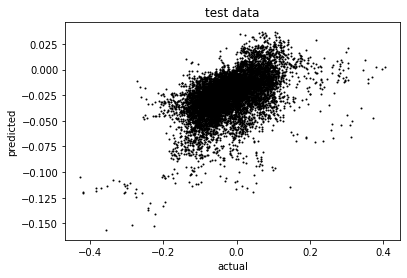

In [47]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

### Weight $w = \text{Optimal}$

In [48]:
yhat_ts = model_ts.predict(trainX_ts).reshape(-1)
yhat_alt = model_alt.predict(trainX).reshape(-1)
yact = trainY.reshape(-1)
w = sum((yact-yhat_alt)*(yhat_ts-yhat_alt))/sum((yhat_ts-yhat_alt)**2)
w

0.24063370947387572

In [49]:
yhat_ts = model_ts.predict(testX_ts).reshape(-1)
yhat_alt = model_alt.predict(testX).reshape(-1)
yhat = w*yhat_ts+(1-w)*yhat_alt
yact = testY.reshape(-1)

Test RMSE: 0.0615


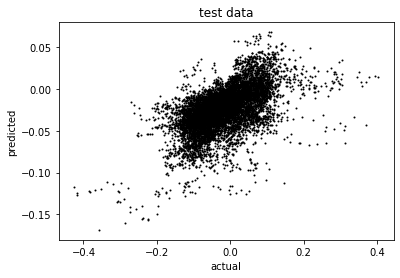

In [50]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yact, yhat))
print('Test RMSE: %.4f' % rmse)
# plot pred vs actual　
plt.scatter(yact, yhat, s=1, c='k')
plt.title('test data')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()